In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The following seciont involves importing necessary libraries and determining the computation device. This ensures access to crucial functionalities for data retrieval, preprocessing, deep learning, and visualization. By checking for the availability of a GPU, computational efficiency is optimized, and the appropriate device is assigned for processing tasks. Additionally, the data retrieval mechanism is set up by overriding the method in pandas_datareader, allowing for seamless integration with yfinance.

In [76]:
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import inspect
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

In [77]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Parameters necessary for fetching historical stock data and generating sequences are defined. The choice of stock ('AAPL' for Apple Inc.), start and end dates, along with multiple sequence lengths, are specified strategically. These parameters lay the groundwork for subsequent data fetching and preprocessing steps, tailoring the analysis to specific requirements.

Historical stock data is fetched using Yahoo Finance and preprocessed for further analysis. The fetched data is augmented with additional information, such as the percentage change in adjusted close prices, facilitating deeper insights into stock performance. By removing the initial row to handle potential NaN values resulting from percentage change calculations, the data is made robust for subsequent processing steps. This section establishes the foundational data infrastructure necessary for subsequent analysis, including sequence generation and deep learning tasks.

We chose the sequence lengths 60 and 100 because they offer a balanced representation of both short-term and medium-term patterns in stock data. With a sequence length of 60, each sequence captures the dynamics of one trading hour, allowing the model to discern short-term fluctuations, intraday trends, and responses to immediate market events. This granularity is essential for capturing rapid changes in stock prices and identifying short-term trading opportunities based on intraday patterns.

On the other hand, a sequence length of 100 encompasses approximately one trading day, providing a broader context for analyzing stock data. This longer-term perspective enables the model to capture medium-term trends, daily price movements, and recurring patterns that unfold over the course of a trading session. By including both short-term and medium-term sequences, the model can gain insights into various time scales of market dynamics, thereby enhancing its ability to make accurate predictions and informed trading decisions.

In [97]:
yf.pdr_override()

# Define parameters
ticker = 'AAPL'  # Example ticker symbol for Apple Inc.
start_date = '2004-01-01'
end_date = '2024-01-01'
sequence_lengths = [60, 100]  # Length of each sequence


# Fetch data
data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
data['Adj Close Percent Change'] = data['Adj Close'].pct_change()
data = data[1:] # Remove the NAN row for pct_change
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Adj Close Percent Change
Date,,,,,,,
2004-01-05,0.382500,0.399821,0.382500,0.395893,0.335163,395018400,0.041823
2004-01-06,0.397321,0.400357,0.387679,0.394464,0.333953,509348000,-0.003610
2004-01-07,0.394643,0.407679,0.391607,0.403393,0.341512,586874400,0.022636
2004-01-08,0.407857,0.423750,0.404464,0.417143,0.353153,460303200,0.034086
2004-01-09,0.414821,0.430893,0.406964,0.410714,0.347710,427459200,-0.015412
...,...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.353287,37122800,-0.005547
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.803986,28919300,-0.002841
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.903839,48087700,0.000518


In [98]:
with open('/content/drive/My Drive/data.txt', 'w') as f:
    f.write(str(data))

The data is split into training, validation, and test sets using the train_test_split function from scikit-learn. The test_data is set to 20% of the entire dataset, and the random_state parameter ensures reproducibility. The remaining data is further split into train_data and val_data, with the training data being 80% of the remaining data and the validation data being 20%. This splitting ensures that the model is trained on a portion of the data, validated on another portion, and tested on a separate set, preventing overfitting and providing a reliable evaluation metric.

We split the data prior to scaling because it's essential to maintain the integrity of the model evaluation process and prevent data leakage. By splitting the data into training, validation, and test sets before scaling, we ensure that each set is treated independently. This approach guarantees that the scaling parameters are derived solely from the training data, maintaining the separation between training and evaluation data. It's crucial for preventing any information leakage and providing a reliable assessment of model performance on unseen data. This adherence to maintaining the integrity of the validation and test sets is essential for accurate model evaluation and generalization to new data.

In [99]:
# Split data

train_val_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

Following data splitting, preprocessing steps are executed to scale the data using MinMaxScaler from scikit-learn. This scaler transforms each feature to a specified range, usually between 0 and 1, preserving the shape of the original distribution. The training, validation, and test data are scaled separately to avoid data leakage and maintain independence between sets. By applying scaling, the model's convergence is improved, and the optimization process becomes more stable, as features are brought to a similar scale.


We chose to use MinMaxScaler() rather than StandardScaler() because of several reasons specific to stock data prediction. Firstly, stock data often exhibits non-linear patterns and varying magnitudes across different features, making it crucial to scale the data appropriately. MinMaxScaler() ensures that all features are scaled to a common range (typically between 0 and 1), preserving the relative relationships between them. This preservation is vital for capturing the underlying patterns and dynamics present in stock data, allowing predictive models to better understand and utilize the information encoded in each feature.

Secondly, stock data is highly susceptible to outliers, which can significantly skew statistical measures like the mean and standard deviation used by StandardScaler(). By scaling the data based on the minimum and maximum values, MinMaxScaler() is less influenced by outliers and extreme values, leading to more robust and reliable predictions. This robustness is particularly beneficial in financial markets, where unexpected events or extreme price movements can occur frequently.

Additionally, MinMaxScaler() offers simplicity and interpretability, which are valuable traits in stock prediction models. Since it linearly scales the data to a predefined range, it's easier to understand and interpret the scaled features' values, aiding in model analysis and decision-making. This simplicity also facilitates the implementation and deployment of predictive models in real-world trading environments, where computational efficiency and ease of use are paramount.

In [101]:
# Preprocess data
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.fit_transform(val_data)
test_data_scaled = scaler.fit_transform(test_data)

After preprocessing, the mean and standard deviation of each feature in the scaled datasets are calculated. This information provides insights into the distribution of features within each dataset. The meanStd function iterates over each feature and prints its corresponding mean and standard deviation. Analyzing these statistics helps ensure that the data is properly normalized and provides a basis for understanding the characteristics of the input features. Printing these statistics aids in validating the preprocessing steps and understanding the scale and distribution of the features in each dataset.

In [102]:
# Check the mean and standard deviation of each feature
train_mean_values = np.mean(train_data_scaled, axis=0)
train_std_dev_values = np.std(train_data_scaled, axis=0)

val_mean_values = np.mean(val_data_scaled, axis=0)
val_std_dev_values = np.std(val_data_scaled, axis=0)

test_mean_values = np.mean(test_data_scaled, axis=0)
test_std_dev_values = np.std(test_data_scaled, axis=0)

# Print the mean and standard deviation for each feature
def meanStd(mean_values, std_dev_values):
  for i, (mean, std_dev) in enumerate(zip(mean_values, std_dev_values)):
      print(f"Feature {i+1}: Mean={mean}, Std Dev={std_dev}")

meanStd(train_mean_values, train_std_dev_values)
print("\n")
meanStd(val_mean_values, val_std_dev_values)
print("\n")
meanStd(test_mean_values, test_std_dev_values)

Feature 1: Mean=0.21773778228898014, Std Dev=0.2696794398436429
Feature 2: Mean=0.21825031904771522, Std Dev=0.2703782289522321
Feature 3: Mean=0.2165180117416659, Std Dev=0.2681782083012858
Feature 4: Mean=0.2176804703722342, Std Dev=0.2696227289548314
Feature 5: Mean=0.210077021719029, Std Dev=0.2694422121956743
Feature 6: Mean=0.11221300755554967, Std Dev=0.1188013694875672
Feature 7: Mean=0.4858809636714596, Std Dev=0.07651563584919688


Feature 1: Mean=0.21655955506793242, Std Dev=0.270639916479475
Feature 2: Mean=0.21702976406810193, Std Dev=0.2715198549192027
Feature 3: Mean=0.21493827164996418, Std Dev=0.26877783078125644
Feature 4: Mean=0.21516303331302566, Std Dev=0.26921000100154924
Feature 5: Mean=0.20722073388380788, Std Dev=0.2688943742284098
Feature 6: Mean=0.1582810388981808, Std Dev=0.16290602595755876
Feature 7: Mean=0.5027115016352228, Std Dev=0.08275882753215079


Feature 1: Mean=0.21101189088034664, Std Dev=0.2708496420485672
Feature 2: Mean=0.21106312146160422, St


A function named seqLabels is defined to generate sequences of a specified length (seq_len) from a given feature. It iterates over the feature data and appends sequences to the seq list, while also capturing the first and last elements of each sequence and appending them to the labels_first and labels_last lists, respectively. This function encapsulates the process of creating sequences from the data, ensuring that both the input sequences and their corresponding labels are properly constructed.

Within a loop iterating over each sequence length specified in the sequence_lengths list, sequences are generated for the training, validation, and test sets. For each sequence length, separate sequences and labels are generated for the training, validation, and test datasets using the seqLabels function. This ensures that sequences of varying lengths are created for each dataset, facilitating experimentation and model training with different sequence lengths.

After generating sequences for each dataset, the sequences are converted to list objects to ensure compatibility with further processing steps. This conversion is necessary as some subsequent operations may require sequences to be in a specific format or data type. The resulting sequences, along with their corresponding labels, are then stored in a dictionary named sequences_by_length, organized by sequence length. This dictionary serves as a convenient container for accessing sequences and labels for different sequence lengths during subsequent model training and evaluation.

In [103]:
def seqLabels(seq, feature, seq_len, labels_first, labels_last):
  for i in range(len(feature) - seq_len):
      seq.append(feature.iloc[i+1:i+seq_len-1])
      labels_first.append(feature.iloc[i][-1])  # First element of the sequence
      labels_last.append(feature.iloc[i+seq_len-1][-1])  # Last element of the sequence


sequences_by_length = {}

# For each sequence length, generate sequences for train, validation, and test sets
for seq_length in sequence_lengths:
    train_sequences = []
    train_labels_first = []
    train_labels_last = []
    seqLabels(train_sequences, train_data, seq_length, train_labels_first, train_labels_last)

    val_sequences = []
    val_labels_first = []
    val_labels_last = []
    seqLabels(val_sequences, val_data, seq_length, val_labels_first, val_labels_last)

    test_sequences = []
    test_labels_first = []
    test_labels_last = []
    seqLabels(test_sequences, test_data, seq_length, test_labels_first, test_labels_last)

    # Convert sequences to list object
    train_sequences = np.array(train_sequences)
    train_sequences = train_sequences.tolist()
    val_sequences = np.array(val_sequences)
    val_sequences = val_sequences.tolist()
    test_sequences = np.array(test_sequences)
    test_sequences = test_sequences.tolist()

    # Store sequences for the current sequence length in the dictionary
    sequences_by_length[seq_length] = {
        'train_sequences': train_sequences,
        'train_labels_first': train_labels_first,
        'train_labels_last': train_labels_last,
        'val_sequences': val_sequences,
        'val_labels_first': val_labels_first,
        'val_labels_last': val_labels_last,
        'test_sequences': test_sequences,
        'test_labels_first': test_labels_first,
        'test_labels_last': test_labels_last
    }

In [104]:
with open('/content/drive/My Drive/sequences_by_length.txt', 'w') as f:
    f.write(str(sequences_by_length))

For each specified sequence length in the sequence_lengths list, sequences and their corresponding labels are converted into PyTorch tensors. This conversion is essential for compatibility with PyTorch's deep learning framework. The sequences and labels for the training, validation, and test sets are retrieved from the sequences_by_length dictionary and converted into tensors using the torch.FloatTensor constructor. These tensors are then transferred to the appropriate computation device, whether CPU or GPU, using the to method.

After converting sequences and labels to tensors and transferring them to the desired device, DataLoaders are created for each dataset. DataLoaders facilitate efficient batch-wise processing of data during model training and evaluation. Using the torch.utils.data.TensorDataset constructor, each dataset's tensors are combined into a single dataset object, which is then passed to the DataLoader constructor. The DataLoaders are configured with a specified batch size and whether to shuffle the data, ensuring randomness in the order of batches during training while maintaining the sequence of data points during evaluation.

The created DataLoaders are then stored back into the sequences_by_length dictionary for easy access during model training and evaluation. Each sequence length's corresponding entry in the dictionary now contains DataLoaders for the training, validation, and test sets, enabling seamless integration of the data with deep learning models. This section of the code establishes the data pipeline, from converting raw sequences into tensors to creating DataLoaders for efficient data processing, laying the foundation for subsequent model training and evaluation.

In [105]:
for seq_length in sequence_lengths:
    # Convert sequences to PyTorch tensors
    X_train_tensor = torch.FloatTensor(sequences_by_length[seq_length]['train_sequences'])
    y_train_first_tensor = torch.FloatTensor(sequences_by_length[seq_length]['train_labels_first'])
    y_train_last_tensor = torch.FloatTensor(sequences_by_length[seq_length]['train_labels_last'])
    X_val_tensor = torch.FloatTensor(sequences_by_length[seq_length]['val_sequences'])
    y_val_first_tensor = torch.FloatTensor(sequences_by_length[seq_length]['val_labels_first'])
    y_val_last_tensor = torch.FloatTensor(sequences_by_length[seq_length]['val_labels_last'])
    X_test_tensor = torch.FloatTensor(sequences_by_length[seq_length]['test_sequences'])
    y_test_first_tensor = torch.FloatTensor(sequences_by_length[seq_length]['test_labels_first'])
    y_test_last_tensor = torch.FloatTensor(sequences_by_length[seq_length]['test_labels_last'])

    X_train_tensor = X_train_tensor.to(device)
    y_train_first_tensor = y_train_first_tensor.to(device)
    y_train_last_tensor = y_train_last_tensor.to(device)

    X_val_tensor = X_val_tensor.to(device)
    y_val_first_tensor = y_val_first_tensor.to(device)
    y_val_last_tensor = y_val_last_tensor.to(device)

    X_test_tensor = X_test_tensor.to(device)
    y_test_first_tensor = y_test_first_tensor.to(device)
    y_test_last_tensor = y_test_last_tensor.to(device)

    # Create DataLoaders
    batch_size = 5
    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_first_tensor, y_train_last_tensor)
    train_loader_input = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_first_tensor, y_val_last_tensor)
    val_loader_input = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_first_tensor, y_test_last_tensor)
    test_loader_input = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Store the DataLoaders in the dictionary
    sequences_by_length[seq_length]['train_loader'] = train_loader_input
    sequences_by_length[seq_length]['val_loader'] = val_loader_input
    sequences_by_length[seq_length]['test_loader'] = test_loader_input


In [106]:
with open('/content/drive/My Drive/sequences_by_length_loaders.txt', 'w') as f:
    f.write(str(sequences_by_length))

The following section defined model named BiGRU, which implements a bidirectional Gated Recurrent Unit (GRU) neural network architecture. Inside the init method, the model's architecture is initialized. The constructor accepts parameters such as the number of input features (num_inputs), the number of hidden units (num_hiddens), the number of GRU layers (num_layers), and a parameter for initializing weights (sigma). These parameters are stored as attributes of the class. Two GRU layers are instantiated: f_rnn for the forward direction and b_rnn for the backward direction. The output dimension of the hidden units is doubled (self.num_hiddens *= 2) because the outputs from both forward and backward directions are concatenated. Finally, a linear layer is defined to map the concatenated outputs to a single output.

The forward method defines the forward pass of the model. It takes inputs and an optional hidden state (Hs) as input arguments. Inside the method, the forward (f_rnn) and backward (b_rnn) GRU layers process the input sequences in their respective directions. The outputs from both directions are concatenated along the feature dimension using torch.cat. Then, a linear layer is applied to transform the concatenated outputs to the desired output dimension. The method returns the first and last elements of the output sequences (outputs[:, [0, -1], :]) along with the final hidden states for both forward and backward directions.

In [108]:
class BiGRU(nn.Module):

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

    def __init__(self, num_inputs, num_hiddens, num_layers=1, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.num_inputs = int(num_inputs)
        self.num_hiddens = int(num_hiddens)
        self.f_rnn = nn.GRU(num_inputs, num_hiddens, num_layers=num_layers)
        self.b_rnn = nn.GRU(num_inputs, num_hiddens, num_layers=num_layers)
        self.num_hiddens *= 2  # The output dimension will be doubled

        # Final linear layer
        self.linear = nn.Linear(self.num_hiddens, 1)

    def forward(self, inputs, Hs=None):
      f_H, b_H = Hs if Hs is not None else (None, None)
      f_outputs, f_H = self.f_rnn(inputs, f_H)
      b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
      outputs = torch.cat((f_outputs, reversed(b_outputs)), dim=2)

      # Apply linear layer
      outputs = self.linear(outputs)

      return outputs[:, [0, -1], :], (f_H, b_H)

The next section defines another model, BiLSTM, which implements a bidirectional Long Short-Term Memory (LSTM) neural network architecture. Like the previous BiGRU module, this module also has a save_hyperparameters method and an init method.

In the init method, the architecture of the bidirectional LSTM model is initialized. The constructor accepts parameters such as the number of input features (num_inputs), the number of hidden units (num_hiddens), the number of LSTM layers (num_layers), and a parameter for initializing weights (sigma). Two LSTM layers are instantiated: f_rnn for the forward direction and b_rnn for the backward direction. Similar to the BiGRU module, the output dimension of the hidden units is doubled (self.num_hiddens *= 2) because the outputs from both forward and backward directions are concatenated. Finally, a linear layer is defined to map the concatenated outputs to a single output.

The forward method defines the forward pass of the model. It takes inputs and an optional hidden state (Hs) as input arguments. Inside the method, the forward (f_rnn) and backward (b_rnn) LSTM layers process the input sequences in their respective directions. The outputs from both directions are concatenated along the feature dimension using torch.cat. Then, a linear layer is applied to transform the concatenated outputs to the desired output dimension. The method returns the first and last elements of the output sequences (outputs[:, [0, -1], :]) along with the final hidden states for both forward and backward directions.

In [109]:
class BiLSTM(nn.Module):

    def save_hyperparameters(self, ignore=[]):
        """Save function arguments into class attributes."""
        frame = inspect.currentframe().f_back
        _, _, _, local_vars = inspect.getargvalues(frame)
        self.hparams = {k:v for k, v in local_vars.items()
                        if k not in set(ignore+['self']) and not k.startswith('_')}
        for k, v in self.hparams.items():
            setattr(self, k, v)

    def __init__(self, num_inputs, num_hiddens, num_layers=1, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.num_inputs = int(num_inputs)
        self.num_hiddens = int(num_hiddens)
        self.f_rnn = nn.LSTM(num_inputs, num_hiddens, num_layers=num_layers)
        self.b_rnn = nn.LSTM(num_inputs, num_hiddens, num_layers=num_layers)
        self.num_hiddens *= 2  # The output dimension will be doubled

        # Final linear layer
        self.linear = nn.Linear(self.num_hiddens, 1)

    def forward(self, inputs, Hs=None):
      f_H, b_H = Hs if Hs is not None else (None, None)
      f_outputs, f_H = self.f_rnn(inputs, f_H)
      b_outputs, b_H = self.b_rnn(reversed(inputs), b_H)
      outputs = torch.cat((f_outputs, reversed(b_outputs)), dim=2)

      # Apply linear layer
      outputs = self.linear(outputs)

      return outputs[:, [0, -1], :], (f_H, b_H)


We chose GRU and LSTM because of their established effectiveness in capturing temporal dependencies and intricate patterns in sequential data like stock prices. The gated mechanisms in GRUs and LSTMs facilitate the retention of information over long sequences, enabling them to model the complex dynamics of stock data accurately. Additionally, their ability to mitigate the vanishing gradient problem ensures more stable training, resulting in better predictive performance.

In the future, we would explore the use of Transformers for stock data prediction. Transformers offer several advantages, including their parallelism, scalability, and superior ability to capture long-range dependencies. Their self-attention mechanism allows them to process input sequences in parallel, making them highly efficient for modeling large datasets such as historical stock price data. By leveraging Transformers, we aim to further enhance our models' capability to uncover intricate relationships and patterns within stock data, potentially leading to more accurate and insightful predictions.

The train function is responsible for training the neural network model. This function takes several arguments: the model to be trained (model), the data loader for the training dataset (train_loader), the loss criterion (criterion), the optimizer (optimizer), the number of epochs to train (epochs), and the device to be used for training (device).

Inside the function, the model is set to training mode (model.train()) and moved to the specified device (model.to(device)). Two lists, loss_trend_backward and loss_trend_forward, are initialized to store the trend of loss values during training for the backward and forward passes, respectively.

The function then iterates over each epoch. Within each epoch, it iterates over the batches of data provided by the train_loader. For each batch, it performs the following steps:

* Transfers the input sequences and labels to the specified device.
* Resets the gradients of the optimizer (optimizer.zero_grad()).
* Performs the forward pass through the model to obtain the model predictions (outputs).
* Separates the predictions into the first and last elements of each sequence.
* Calculates the L1 and L2 loss values (loss_1 and loss_2) between the predicted and true values.
* Computes the total loss as the sum of the L1 and L2 losses.
* Performs the backward pass to compute the gradients of the loss with respect to the model parameters (loss.backward()).
* Updates the model parameters using the optimization algorithm (optimizer.step()).

After completing training for each epoch, the function prints the average loss, L1 loss, and L2 loss over the entire training dataset for that epoch. This information helps monitor the training progress. Finally, the function returns the trained model, criterion, optimizer, and the lists containing the loss trends for the backward and forward passes.

In [110]:
def train(model, train_loader, criterion, optimizer, epochs=10, device=device):
    model.train()  # Set the model to training mode
    model.to(device)  # Move model to the specified device (e.g., GPU)

    loss_trend_backward = []
    loss_trend_forward = []

    for epoch in range(epochs):
        total_loss = 0.0
        total_L1 = 0.0
        total_L2 = 0.0

        for sequences, first_labels, last_labels in train_loader:
            sequences, first_labels, last_labels = sequences.to(device), first_labels.to(device), last_labels.to(device)

            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs, _ = model(sequences)

            # Separate outputs into first and last elements
            batch_size = outputs.size(0)
            predicted_first = outputs[:, 0, 0]
            predicted_last = outputs[:, -1, -1]

            # Calculate L1 and L2 losses
            loss_1 = criterion(predicted_first, first_labels)
            loss_2 = criterion(predicted_last, last_labels)

            loss_trend_backward.append(loss_1)
            loss_trend_forward.append(loss_2)

            # Total loss as the sum of L1 and L2 losses
            loss = loss_1 + loss_2
            total_L1 += loss_1.item()
            total_L2 += loss_2.item()
            total_loss += loss.item()

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

        # Print average loss for the epoch
        if (epoch+1) % 10 == 0 or epoch == 0:
          print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss / len(train_loader):.10f}, L1: {total_L1 / len(train_loader):.10f}, L2: {total_L2 / len(train_loader):.10f}")
    return model, criterion, optimizer, loss_trend_backward, loss_trend_forward

We define two functions: GRUModelRun and LSTMModelRun, responsible for running the GRU and LSTM models, respectively.

For the GRUModelRun function:

* It initializes a GRU model (model_GRU) using the BiGRU class with the specified number of input features (num_inputs=7) and hidden units (num_hiddens=hiddens).
* The model is moved to the specified device (device).
* The mean squared error loss criterion (nn.MSELoss()) is initialized as criterion_GRU.
* An Adam optimizer is initialized (optim.Adam) to optimize the model parameters with the specified learning rate (learning_rate).
* The train function is called to train the GRU model using the training data loader, criterion, optimizer, and other specified parameters (epochs=100, device=device).
* The function returns the trained GRU model, criterion, optimizer, and lists containing the loss trends for the backward and forward passes (loss_trend_backward_GRU and loss_trend_forward_GRU).

For the LSTMModelRun function:

* It initializes an LSTM model (model_LSTM) using the BiLSTM class with the specified number of input features (num_inputs=7) and hidden units (num_hiddens=hiddens).
* The model is moved to the specified device (device).
* The mean squared error loss criterion (nn.MSELoss()) is initialized as criterion_LSTM.
* An Adam optimizer is initialized (optim.Adam) to optimize the model parameters with the specified learning rate (learning_rate).
* The train function is called to train the LSTM model using the training data loader, criterion, optimizer, and other specified parameters (epochs=100, device=device).
* The function returns the trained LSTM model, criterion, optimizer, and lists containing the loss trends for the backward and forward passes (loss_trend_backward_LSTM and loss_trend_forward_LSTM).

These functions encapsulate the process of initializing, training, and evaluating the GRU and LSTM models, making it convenient to experiment with different hyperparameters and model architectures.

We decided to use Mean Squared Error because when working with stock data, MSE is often preferred as the loss function over Mean Absolute Error (MAE) for several reasons:

* Sensitivity to Outliers: MSE penalizes large errors more heavily than MAE. In the context of stock data, where extreme fluctuations or outliers can occur, MSE provides a stronger signal for the model to adjust its parameters in response to these outliers. This can help the model better capture the patterns and trends in the data, especially during volatile market conditions.
* Differentiation Properties: MSE is differentiable everywhere, whereas MAE is not differentiable at zero. This property makes it easier to apply optimization techniques such as gradient descent, which rely on derivatives, when using MSE. In stock prediction models, where optimization is crucial for training neural networks, MSE offers computational advantages.
* Squaring Effect: Squaring the errors in MSE amplifies the impact of larger errors compared to smaller ones. In financial forecasting, where accurately predicting large movements in stock prices is often more important than small fluctuations, this emphasis on larger errors can lead to models that prioritize capturing significant market shifts.

In [111]:
# GRU Model:
def GRUModelRun(seq_len, hiddens, learning_rate):
  print("\n GRU Model")
  model_GRU = BiGRU(num_inputs=7, num_hiddens=hiddens)
  model_GRU.to(device)
  criterion_GRU = nn.MSELoss()
  optimizer_GRU = optim.Adam(model_GRU.parameters(), lr=learning_rate)
  model_GRU, criterion_GRU, optimizer_GRU, loss_trend_backward_GRU, loss_trend_forward_GRU = train(model_GRU, sequences_by_length[seq_len]['train_loader'], criterion_GRU, optimizer_GRU, epochs=100, device=device)
  return model_GRU, criterion_GRU, optimizer_GRU, loss_trend_backward_GRU, loss_trend_forward_GRU

# LSTM Model:
def LSTMModelRun(seq_len, hiddens, learning_rate):
  print("\n LSTM Model")
  model_LSTM = BiLSTM(num_inputs=7, num_hiddens=hiddens)
  model_LSTM.to(device)
  criterion_LSTM = nn.MSELoss()
  optimizer_LSTM = optim.Adam(model_LSTM.parameters(), lr=learning_rate)

  model_LSTM, criterion_LSTM, optimizer_LSTM, loss_trend_backward_LSTM, loss_trend_forward_LSTM = train(model_LSTM, sequences_by_length[seq_len]['train_loader'], criterion_LSTM, optimizer_LSTM, epochs=100, device=device)
  return model_LSTM, criterion_LSTM, optimizer_LSTM, loss_trend_backward_LSTM, loss_trend_forward_LSTM

The provided code defines a function hidden_learning_combo that iterates over combinations of hidden layer sizes and learning rates to train both GRU and LSTM models.

* It imports the necessary module product from itertools.
* Defines lists hidden_layers and learning_rates containing different values for hidden layer sizes and learning rates, respectively.
* The function hidden_learning_combo takes three parameters: seq_len (sequence length), hl (list of hidden layer sizes), and lr (list of learning rates).
* Inside the function, dictionaries are initialized to store models, criteria, optimizers, and loss trends for both GRU and LSTM models.
* It iterates over all combinations of hidden layer sizes and learning rates using product(hl, lr).
* For each combination, it calls the GRUModelRun and LSTMModelRun functions to train the GRU and LSTM models, respectively, with the specified sequence length, hidden layer size, and learning rate.
* The trained models, criteria, optimizers, and loss trends are saved into the corresponding dictionaries.
* Finally, the function returns all these dictionaries containing the trained models and associated information.

This function allows for an automated exploration of different combinations of hyperparameters, facilitating the training and evaluation of GRU and LSTM models for various scenarios.

In [112]:
# Import necessary modules
from itertools import product

hidden_layers = [32, 64, 128]
learning_rates = [0.01, 0.001]

def hidden_learning_combo(seq_len, hl, lr):
    # Initialize dictionaries to store models, criteria, and optimizers
    models_GRU = {}
    criterions_GRU = {}
    optimizers_GRU = {}
    loss_trends_backward_GRU = {}
    loss_trends_forward_GRU = {}
    models_LSTM = {}
    criterions_LSTM = {}
    optimizers_LSTM = {}
    loss_trends_backward_LSTM = {}
    loss_trends_forward_LSTM = {}

    # Iterate over all combinations of hidden layer sizes and learning rates
    for i, j in product(hl, lr):
        # Run GRU model
        model_GRU, criterion_GRU, optimizer_GRU, loss_trend_backward_GRU, loss_trend_forward_GRU = GRUModelRun(seq_len, i, j)
        # Run LSTM model
        model_LSTM, criterion_LSTM, optimizer_LSTM, loss_trend_backward_LSTM, loss_trend_forward_LSTM = LSTMModelRun(seq_len, i, j)

        # Save models, criteria, and optimizers to dictionaries
        models_GRU[(i, j)] = model_GRU
        criterions_GRU[(i, j)] = criterion_GRU
        optimizers_GRU[(i, j)] = optimizer_GRU
        loss_trends_backward_GRU[(i, j)] = loss_trend_backward_GRU
        loss_trends_forward_GRU[(i, j)] = loss_trend_forward_GRU
        models_LSTM[(i, j)] = model_LSTM
        criterions_LSTM[(i, j)] = criterion_LSTM
        optimizers_LSTM[(i, j)] = optimizer_LSTM
        loss_trends_backward_LSTM[(i, j)] = loss_trend_backward_LSTM
        loss_trends_forward_LSTM[(i, j)] = loss_trend_forward_LSTM

    return models_GRU, criterions_GRU, optimizers_GRU, loss_trends_backward_GRU, loss_trends_forward_GRU, models_LSTM, criterions_LSTM, optimizers_LSTM, loss_trends_backward_LSTM, loss_trends_forward_LSTM


# models_GRU, criterions_GRU, optimizers_GRU, loss_trend_backward_GRU, loss_trend_forward_GRU, models_LSTM, criterions_LSTM, optimizers_LSTM, loss_trend_backward_LSTM, loss_trend_forward_LSTM = hidden_learning_combo(sequence_length, hidden_layers, learning_rates)


The provided code segment iterates over each sequence length and performs an exploration of various combinations of hyperparameters for both GRU and LSTM models, storing the results for each combination.

* It initializes a dictionary hidden_learning_combo_by_sequence_length to store results for each sequence length.
* It iterates over each sequence length in the list sequence_lengths.
Within each iteration, it initializes a dictionary result_for_sequence_length to store results for the current sequence length.
* It calls the function hidden_learning_combo to explore different combinations of hidden layer sizes and learning rates for the current sequence length.
* The results obtained from hidden_learning_combo are stored in the result_for_sequence_length dictionary.
* For each combination of hidden layer size and learning rate, the dictionary stores the trained models, criteria, optimizers, and loss trends for both GRU and LSTM models.
* The results for the current sequence length are stored in the outer dictionary hidden_learning_combo_by_sequence_length.
* This process repeats for each sequence length, ultimately populating the hidden_learning_combo_by_sequence_length dictionary with results for all sequence lengths.

In [115]:
# Dictionary to store results for each sequence length
hidden_learning_combo_by_sequence_length = {}

# Iterate over each sequence length
for seq_length in sequence_lengths:
    # Initialize a dictionary to store results for this sequence length
    result_for_sequence_length = {}

    # Run the function hidden_learning_combo for the current sequence length
    models_GRU, criterions_GRU, optimizers_GRU, loss_trends_backward_GRU, loss_trends_forward_GRU, models_LSTM, criterions_LSTM, optimizers_LSTM, loss_trends_backward_LSTM, loss_trends_forward_LSTM = hidden_learning_combo(seq_length, hidden_layers, learning_rates)

    # Store the results in a dictionary for the current sequence length
    for i, hidden_layer_size in enumerate(hidden_layers):
        for j, learning_rate in enumerate(learning_rates):
            result_for_sequence_length[(hidden_layer_size, learning_rate)] = {
                'models_GRU': models_GRU[(hidden_layer_size, learning_rate)],
                'criterions_GRU': criterions_GRU[(hidden_layer_size, learning_rate)],
                'optimizers_GRU': optimizers_GRU[(hidden_layer_size, learning_rate)],
                'loss_trends_backward_GRU': loss_trends_backward_GRU[(hidden_layer_size, learning_rate)],
                'loss_trends_forward_GRU': loss_trends_forward_GRU[(hidden_layer_size, learning_rate)],
                'models_LSTM': models_LSTM[(hidden_layer_size, learning_rate)],
                'criterions_LSTM': criterions_LSTM[(hidden_layer_size, learning_rate)],
                'optimizers_LSTM': optimizers_LSTM[(hidden_layer_size, learning_rate)],
                'loss_trends_backward_LSTM': loss_trends_backward_LSTM[(hidden_layer_size, learning_rate)],
                'loss_trends_forward_LSTM': loss_trends_forward_LSTM[(hidden_layer_size, learning_rate)]
            }

    # Store the results for this sequence length in the outer dictionary
    hidden_learning_combo_by_sequence_length[seq_length] = result_for_sequence_length



 GRU Model
Epoch [1/100], Loss: 0.0021360904, L1: 0.0010884183, L2: 0.0010476722
Epoch [10/100], Loss: 0.0016021368, L1: 0.0007843739, L2: 0.0008177629
Epoch [20/100], Loss: 0.0019549722, L1: 0.0009874335, L2: 0.0009675388
Epoch [30/100], Loss: 0.0016352614, L1: 0.0008089826, L2: 0.0008262788
Epoch [40/100], Loss: 0.0018691760, L1: 0.0009257457, L2: 0.0009434303
Epoch [50/100], Loss: 0.0017700555, L1: 0.0008897617, L2: 0.0008802938
Epoch [60/100], Loss: 0.0018966986, L1: 0.0009353257, L2: 0.0009613729
Epoch [70/100], Loss: 0.0016850282, L1: 0.0008458786, L2: 0.0008391496
Epoch [80/100], Loss: 0.0019861252, L1: 0.0010076613, L2: 0.0009784640
Epoch [90/100], Loss: 0.0019139689, L1: 0.0009474238, L2: 0.0009665450
Epoch [100/100], Loss: 0.0017772226, L1: 0.0008953908, L2: 0.0008818318

 LSTM Model
Epoch [1/100], Loss: 0.0013924846, L1: 0.0006982740, L2: 0.0006942107
Epoch [10/100], Loss: 0.0011601877, L1: 0.0005771645, L2: 0.0005830232
Epoch [20/100], Loss: 0.0011979894, L1: 0.0006010981,

In [116]:
with open('/content/drive/My Drive/hidden_learning_combo_by_sequence_length.txt', 'w') as f:
    f.write(str(hidden_learning_combo_by_sequence_length))

The evaluate function assesses the performance of a trained model on a given dataset. It begins by switching the model to evaluation mode to ensure consistent evaluation results by deactivating dropout and batch normalization layers. The model is then moved to the specified device, such as a GPU, for efficient computation.

Within the evaluation loop, the function iterates over batches of sequences and their corresponding labels. It passes the sequences through the model to obtain predictions for the first and last elements of each sequence. These predictions, along with the true values, are stored for correlation analysis. Using the specified criterion (MSELoss), the function computes individual losses for the first and last elements of each sequence, as well as the total loss, which is accumulated over all batches.

After evaluating all batches, the function calculates several metrics to assess the model's performance. It computes the average loss and individual losses, providing insights into prediction accuracy. Additionally, the Root Mean Squared Error (RMSE) is calculated as a measure of prediction accuracy. Furthermore, the function computes R-squared values to quantify how well the predicted values align with the true values, offering insights into the model's predictive capabilities. Finally, the function returns the evaluation metrics for further analysis and interpretation, aiding in understanding the model's effectiveness in predicting stock data.

In [126]:
def evaluate(model, loader, criterion, device=device):
    model.eval()  # Set the model to evaluation mode
    model.to(device)  # Move model to the specified device (e.g., GPU)
    total_loss = 0.0
    total_L1 = 0.0
    total_L2 = 0.0

    predicted_first_values = []
    predicted_last_values = []
    true_first_values = []
    true_last_values = []

    loss_values_first = []
    loss_values_last = []

    with torch.no_grad():
        for sequences, first_labels, last_labels in loader:
            sequences, first_labels, last_labels = sequences.to(device), first_labels.to(device), last_labels.to(device)

            # Forward pass
            outputs, _ = model(sequences)

            # Separate outputs into first and last elements
            predicted_first = outputs[:, 0, 0]
            predicted_last = outputs[:, -1, -1]

            # Store predicted and true values for correlation analysis
            predicted_first_values.extend(predicted_first.cpu().numpy())
            predicted_last_values.extend(predicted_last.cpu().numpy())
            true_first_values.extend(first_labels.cpu().numpy())
            true_last_values.extend(last_labels.cpu().numpy())

            # Calculate loss
            loss_1 = criterion(predicted_first, first_labels)
            loss_2 = criterion(predicted_last, last_labels)
            loss = loss_1 + loss_2
            total_L1 += loss_1.item()
            total_L2 += loss_2.item()
            total_loss += loss.item()

            loss_values_first.append(loss_1)
            loss_values_last.append(loss_2)

    # Calculate average loss
    avg_loss = total_loss / len(loader)
    avg_L1 = total_L1 / len(loader)
    avg_L2 = total_L2 / len(loader)

    # Calculate RMSE
    rmse = np.sqrt(avg_loss)

    # Calculate R-squared
    r_squared_last = 1 - (np.sum(np.square(np.array(predicted_last_values) - np.array(true_last_values))) / np.sum(np.square(np.array(true_last_values) - np.mean(true_last_values))))
    r_squared_first = 1 - (np.sum(np.square(np.array(predicted_first_values) - np.array(true_first_values))) / np.sum(np.square(np.array(true_first_values) - np.mean(true_first_values))))

    return avg_loss, avg_L1, avg_L2, predicted_first_values, predicted_last_values, true_first_values, true_last_values, rmse, r_squared_first, r_squared_last, loss_values_first, loss_values_last


In [170]:
# Initialize dictionaries to store evaluation results
val_evaluation_results_GRU = {}
val_evaluation_results_LSTM = {}

# Iterate over each sequence length
for seq_length in sequence_lengths:
    # Retrieve the results for this sequence length
    val_results_for_length = hidden_learning_combo_by_sequence_length[seq_length]

    # Iterate over each combination of hidden layers and learning rates
    for (hidden_size, learning_rate), model_info in val_results_for_length.items():
        # Retrieve the model, criterion, and loader
        model_GRU = model_info['models_GRU']
        criterion_GRU = model_info['criterions_GRU']
        loader_GRU = sequences_by_length[seq_length]['val_loader']

        # Evaluate the GRU model
        val_loss_GRU, val_L1_GRU, val_L2_GRU, val_pred_first_GRU, val_pred_last_GRU, val_true_first_GRU, val_true_last_GRU, val_rmse_GRU, val_r_squared_first_GRU, val_r_squared_last_GRU, val_loss_values_first_GRU, val_loss_values_last_GRU = evaluate(model_GRU, loader_GRU, criterion_GRU, device=device)

        # Store evaluation results in dictionary
        val_evaluation_results_GRU[(seq_length, hidden_size, learning_rate)] = {
            "val_loss": val_loss_GRU,
            "val_L1": val_L1_GRU,
            "val_L2": val_L2_GRU,
            "val_pred_first": val_pred_first_GRU,
            "val_pred_last": val_pred_last_GRU,
            "val_true_first": val_true_first_GRU,
            "val_true_last": val_true_last_GRU,
            "val_rmse": val_rmse_GRU,
            "val_r_squared_first": val_r_squared_first_GRU,
            "val_r_squared_last": val_r_squared_last_GRU,
            "val_loss_values_first": val_loss_values_first_GRU,
            "val_loss_values_last": val_loss_values_last_GRU
        }

        with open('/content/drive/My Drive/val_evaluation_results_GRU.txt', 'w') as f:
          f.write(str(val_evaluation_results_GRU))

        # Print evaluation results for GRU model
        print(f"GRU Model with sequence length {seq_length}, hidden size {hidden_size}, and learning rate {learning_rate}:")
        print(f"Total Val Loss: {val_loss_GRU:.4f}, Val Backward Loss: {val_L1_GRU:.4f}, Val Forward Loss: {val_L2_GRU:.4f}, Val RMSE: {val_rmse_GRU:.4f}")
        print("\n")

        # Retrieve the LSTM model and criterion
        model_LSTM = model_info['models_LSTM']
        criterion_LSTM = model_info['criterions_LSTM']
        loader_LSTM = sequences_by_length[seq_length]['val_loader']

        # Evaluate the LSTM model
        val_loss_LSTM, val_L1_LSTM, val_L2_LSTM, val_pred_first_LSTM, val_pred_last_LSTM, val_true_first_LSTM, val_true_last_LSTM, val_rmse_LSTM, val_r_squared_first_LSTM, val_r_squared_last_LSTM, val_loss_values_first_LSTM, val_loss_values_last_LSTM = evaluate(model_LSTM, loader_LSTM, criterion_LSTM, device=device)

        # Store evaluation results in dictionary
        val_evaluation_results_LSTM[(seq_length, hidden_size, learning_rate)] = {
            "val_loss": val_loss_LSTM,
            "val_L1": val_L1_LSTM,
            "val_L2": val_L2_LSTM,
            "val_pred_first": val_pred_first_LSTM,
            "val_pred_last": val_pred_last_LSTM,
            "val_true_first": val_true_first_LSTM,
            "val_true_last": val_true_last_LSTM,
            "val_rmse": val_rmse_LSTM,
            "val_r_squared_first": val_r_squared_first_LSTM,
            "val_r_squared_last": val_r_squared_last_LSTM,
            "val_loss_values_first": val_loss_values_first_LSTM,
            "val_loss_values_last": val_loss_values_last_LSTM
        }

        with open('/content/drive/My Drive/val_evaluation_results_LSTM.txt', 'w') as f:
          f.write(str(val_evaluation_results_LSTM))

        # Print evaluation results for LSTM model
        print(f"LSTM Model with sequence length {seq_length}, hidden size {hidden_size}, and learning rate {learning_rate}:")
        print(f"Total Val Loss: {val_loss_LSTM:.4f}, Val Backward Loss: {val_L1_LSTM:.4f}, Val Forward Loss: {val_L2_LSTM:.4f}, Val RMSE: {val_rmse_LSTM:.4f}")
        print("\n")


GRU Model with sequence length 60, hidden size 32, and learning rate 0.01:
Total Val Loss: 0.0010, Val Backward Loss: 0.0005, Val Forward Loss: 0.0005, Val RMSE: 0.0309


LSTM Model with sequence length 60, hidden size 32, and learning rate 0.01:
Total Val Loss: 0.0016, Val Backward Loss: 0.0008, Val Forward Loss: 0.0008, Val RMSE: 0.0404


GRU Model with sequence length 60, hidden size 32, and learning rate 0.001:
Total Val Loss: 0.0011, Val Backward Loss: 0.0005, Val Forward Loss: 0.0005, Val RMSE: 0.0325


LSTM Model with sequence length 60, hidden size 32, and learning rate 0.001:
Total Val Loss: 0.0009, Val Backward Loss: 0.0004, Val Forward Loss: 0.0004, Val RMSE: 0.0292


GRU Model with sequence length 60, hidden size 64, and learning rate 0.01:
Total Val Loss: 0.0019, Val Backward Loss: 0.0010, Val Forward Loss: 0.0010, Val RMSE: 0.0438


LSTM Model with sequence length 60, hidden size 64, and learning rate 0.01:
Total Val Loss: 0.0030, Val Backward Loss: 0.0015, Val Forward Lo

In [171]:
import pandas as pd
from tabulate import tabulate

# Initialize lists to store results
val_lstm_table_data = []
val_gru_table_data = []

val_lstm_loss_table_data = []
val_gru_loss_table_data = []

# Iterate over each sequence length
for seq_length in sequence_lengths:
    # Retrieve the results for this sequence length
    val_table_results_for_length = hidden_learning_combo_by_sequence_length[seq_length]

    # Iterate over each combination of hidden layers and learning rates
    for (hidden_size, learning_rate), model_info in val_table_results_for_length.items():
        # Retrieve the evaluation results for LSTM model
        lstm_results = val_evaluation_results_LSTM[(seq_length, hidden_size, learning_rate)]
        gru_results = val_evaluation_results_GRU[(seq_length, hidden_size, learning_rate)]

        # Append the results to the table data list
        val_lstm_table_data.append([
            seq_length, hidden_size, learning_rate,
            lstm_results["val_loss"],
            lstm_results["val_L1"],
            lstm_results["val_L2"],
            lstm_results["val_rmse"],
        ])

        val_gru_table_data.append([
            seq_length, hidden_size, learning_rate,
            gru_results["val_loss"],
            gru_results["val_L1"],
            gru_results["val_L2"],
            gru_results["val_rmse"],
        ])

        val_lstm_loss_table_data.append([
            lstm_results['val_loss_values_first'],
            lstm_results['val_loss_values_last']
        ])

        val_gru_loss_table_data.append([
            gru_results['val_loss_values_first'],
            gru_results['val_loss_values_last']
        ])

# Create a DataFrame from the table data
df_lstm = pd.DataFrame(val_lstm_table_data, columns=[
    "Sequence Length", "Hidden Size", "Learning Rate",
    "Validation Loss", "Validation L1", "Validation L2",
    "Validation RMSE"
])

df_gru = pd.DataFrame(val_gru_table_data, columns=[
    "Sequence Length", "Hidden Size", "Learning Rate",
    "Validation Loss", "Validation L1", "Validation L2",
    "Validation RMSE"
])

df_val_lstm_loss_values = pd.DataFrame(val_lstm_loss_table_data, columns=[
    "Validation LSTM Backward Loss", "Validation LSTM Forward Loss"
])

df_val_gru_loss_values = pd.DataFrame(val_gru_loss_table_data, columns=[
    "Validation GRU Backward Loss", "Validation GRU Forward Loss"
])

# Display the DataFrame
print("Evaluation Results for Validation GRU Models")
print(tabulate(df_gru, headers='keys', tablefmt='psql'))
print("\n")
print("Evaluation Results for Validation LSTM Models")
print(tabulate(df_lstm, headers='keys', tablefmt='psql'))


Evaluation Results for Validation GRU Models
+----+-------------------+---------------+-----------------+-------------------+-----------------+-----------------+-------------------+
|    |   Sequence Length |   Hidden Size |   Learning Rate |   Validation Loss |   Validation L1 |   Validation L2 |   Validation RMSE |
|----+-------------------+---------------+-----------------+-------------------+-----------------+-----------------+-------------------|
|  0 |                60 |            32 |           0.01  |       0.000957082 |     0.000483067 |     0.000474015 |         0.0309367 |
|  1 |                60 |            32 |           0.001 |       0.001055    |     0.000533183 |     0.000521816 |         0.0324808 |
|  2 |                60 |            64 |           0.01  |       0.00192201  |     0.000952673 |     0.000969337 |         0.0438407 |
|  3 |                60 |            64 |           0.001 |       0.0014249   |     0.000720974 |     0.000703923 |         0.037747

Looking at the evaluation results above for the validation GRU models, several observations can be made. First, it's evident that the model's performance varies significantly based on hyperparameters such as sequence length, hidden size, and learning rate.

For instance, with a sequence length of 60, the model achieves relatively low validation losses across different configurations. However, as the hidden size increases, the validation loss tends to increase as well. This trend suggests that increasing the hidden size may lead to overfitting or model complexity, especially for larger hidden sizes.

Additionally, varying the learning rate also impacts the model's performance. Lower learning rates generally result in lower validation losses, indicating smoother optimization, but excessively low learning rates may hinder convergence. Conversely, higher learning rates may lead to faster convergence but risk overshooting the optimal solution.

Overall, these results highlight the importance of tuning hyperparameters to achieve the best model performance. It's essential to strike a balance between model complexity (hidden size) and optimization efficiency (learning rate) to avoid overfitting and ensure robust generalization to unseen data.

For the validation LSTM model results, it's evident that different configurations of hyperparameters lead to variations in model performance. The sequence length, hidden size, and learning rate are critical factors influencing the model's ability to predict stock data accurately.

For example, comparing results across different sequence lengths (60 and 100) reveals that certain configurations yield lower validation loss, L1, and L2 values, indicating better performance. Additionally, variations in the learning rate and hidden size result in fluctuations in the validation loss and associated metrics such as RMSE. These observations emphasize the importance of carefully tuning hyperparameters to optimize model performance.

Moreover, the evaluation metrics such as RMSE provide valuable insights into the model's predictive accuracy and goodness of fit. Lower RMSE values indicate better agreement between predicted and actual values. Analyzing these metrics across different hyperparameter configurations helps identify the optimal settings that lead to the most accurate predictions for stock data.

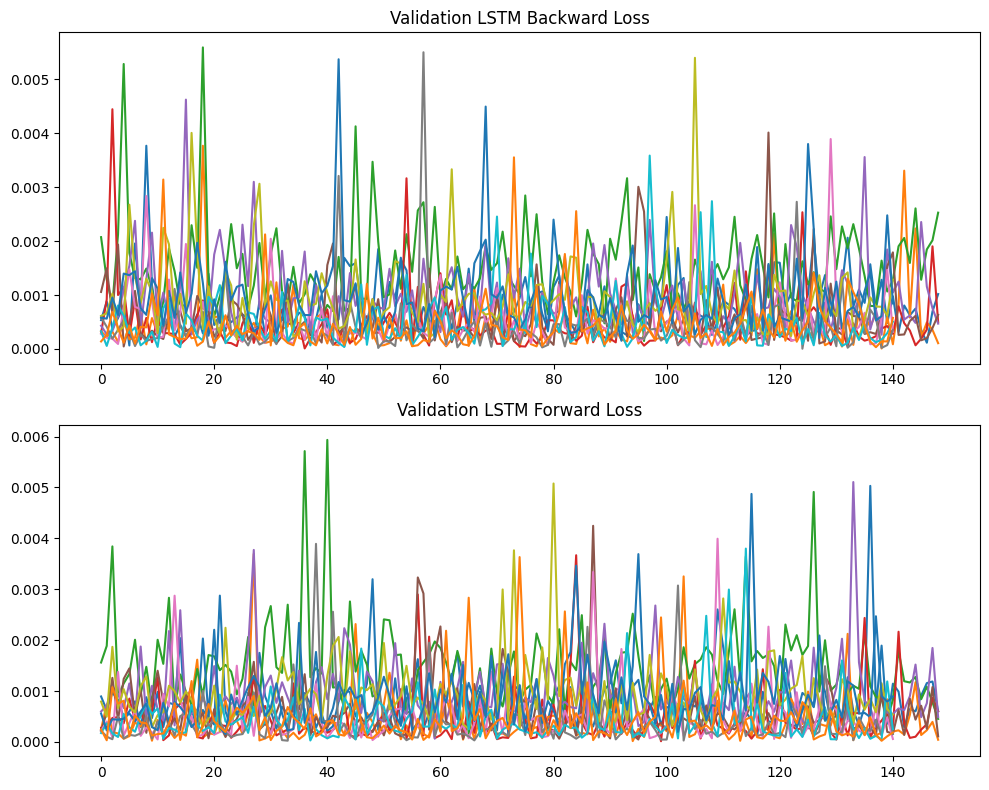

In [172]:
def tensor_to_number(tensor_list):
    return [tensor.item() for tensor in tensor_list]

# Apply the function to each element of the DataFrame
df_val_lstm_loss_values_convert = df_val_lstm_loss_values.applymap(lambda x: tensor_to_number(x))
df_val_gru_loss_values_convert = df_val_gru_loss_values.applymap(lambda x: tensor_to_number(x))


# Plotting
def plotGraph(df):
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

  for i, (col, ax) in enumerate(zip(df.columns, axes)):
      ax.set_title(col)
      for row in df[col]:
          ax.plot(row)

  plt.tight_layout()
  plt.show()

plotGraph(df_val_lstm_loss_values_convert)

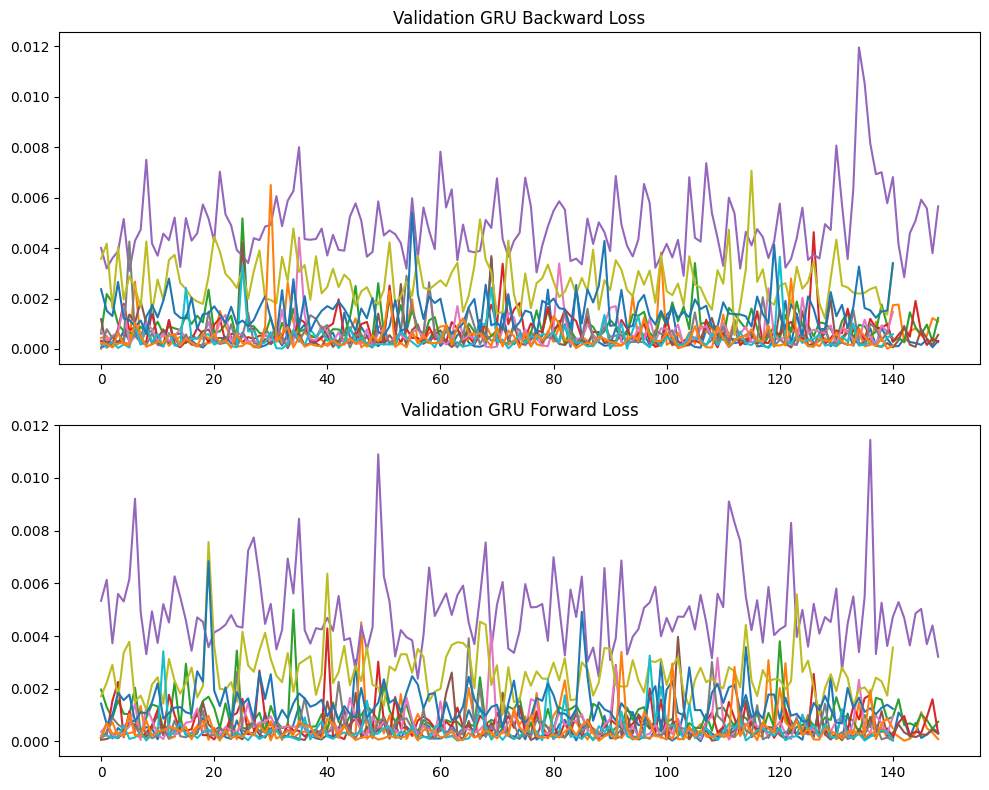

In [173]:
plotGraph(df_val_gru_loss_values_convert)

In [174]:
# Initialize dictionaries to store evaluation results for test data
test_evaluation_results_GRU = {}
test_evaluation_results_LSTM = {}

# Iterate over each sequence length
for seq_length in sequence_lengths:
    # Retrieve the results for this sequence length
    test_results_for_length = hidden_learning_combo_by_sequence_length[seq_length]

    # Iterate over each combination of hidden layers and learning rates
    for (hidden_size, learning_rate), model_info in test_results_for_length.items():
        # Retrieve the model, criterion, and loader for test data
        model_GRU = model_info['models_GRU']
        criterion_GRU = model_info['criterions_GRU']
        loader_GRU = sequences_by_length[seq_length]['test_loader']

        # Evaluate the GRU model on test data
        test_loss_GRU, test_L1_GRU, test_L2_GRU, test_pred_first_GRU, test_pred_last_GRU, test_true_first_GRU, test_true_last_GRU, test_rmse_GRU, test_r_squared_first_GRU, test_r_squared_last_GRU, test_loss_values_first_GRU, test_loss_values_last_GRU = evaluate(model_GRU, loader_GRU, criterion_GRU, device=device)

        # Store evaluation results in dictionary for test data
        test_evaluation_results_GRU[(seq_length, hidden_size, learning_rate)] = {
            "test_loss": test_loss_GRU,
            "test_L1": test_L1_GRU,
            "test_L2": test_L2_GRU,
            "test_pred_first": test_pred_first_GRU,
            "test_pred_last": test_pred_last_GRU,
            "test_true_first": test_true_first_GRU,
            "test_true_last": test_true_last_GRU,
            "test_rmse": test_rmse_GRU,
            "test_r_squared_first": test_r_squared_first_GRU,
            "test_r_squared_last": test_r_squared_last_GRU,
            "test_loss_values_first": test_loss_values_first_GRU,
            "test_loss_values_last": test_loss_values_last_GRU
        }

        with open('/content/drive/My Drive/test_evaluation_results_GRU.txt', 'w') as f:
          f.write(str(test_evaluation_results_GRU))

        # Print evaluation results for GRU model on test data
        print(f"GRU Model with sequence length {seq_length}, hidden size {hidden_size}, and learning rate {learning_rate} (Test Data):")
        print(f"Total Test Loss: {test_loss_GRU:.4f}, Test Backward Loss: {test_L1_GRU:.4f}, Test Forward Loss: {test_L2_GRU:.4f}, Test RMSE: {test_rmse_GRU:.4f}")
        print("\n")

        # Retrieve the LSTM model and criterion for test data
        model_LSTM = model_info['models_LSTM']
        criterion_LSTM = model_info['criterions_LSTM']
        loader_LSTM = sequences_by_length[seq_length]['test_loader']

        # Evaluate the LSTM model on test data
        test_loss_LSTM, test_L1_LSTM, test_L2_LSTM, test_pred_first_LSTM, test_pred_last_LSTM, test_true_first_LSTM, test_true_last_LSTM, test_rmse_LSTM, test_r_squared_first_LSTM, test_r_squared_last_LSTM, test_loss_values_first_LSTM, test_loss_values_last_LSTM = evaluate(model_LSTM, loader_LSTM, criterion_LSTM, device=device)

        # Store evaluation results in dictionary for test data
        test_evaluation_results_LSTM[(seq_length, hidden_size, learning_rate)] = {
            "test_loss": test_loss_LSTM,
            "test_L1": test_L1_LSTM,
            "test_L2": test_L2_LSTM,
            "test_pred_first": test_pred_first_LSTM,
            "test_pred_last": test_pred_last_LSTM,
            "test_true_first": test_true_first_LSTM,
            "test_true_last": test_true_last_LSTM,
            "test_rmse": test_rmse_LSTM,
            "test_r_squared_first": test_r_squared_first_LSTM,
            "test_r_squared_last": test_r_squared_last_LSTM,
            "test_loss_values_first": test_loss_values_first_LSTM,
            "test_loss_values_last": test_loss_values_last_LSTM
        }

        with open('/content/drive/My Drive/test_evaluation_results_LSTM.txt', 'w') as f:
          f.write(str(test_evaluation_results_LSTM))


        # Print evaluation results for LSTM model on test data
        print(f"LSTM Model with sequence length {seq_length}, hidden size {hidden_size}, and learning rate {learning_rate} (Test Data):")
        print(f"Total Test Loss: {test_loss_LSTM:.4f}, Test Backward Loss: {test_L1_LSTM:.4f}, Test Forward Loss: {test_L2_LSTM:.4f}, Test RMSE: {test_rmse_LSTM:.4f}")
        print("\n")


GRU Model with sequence length 60, hidden size 32, and learning rate 0.01 (Test Data):
Total Test Loss: 0.0011, Test Backward Loss: 0.0005, Test Forward Loss: 0.0005, Test RMSE: 0.0325


LSTM Model with sequence length 60, hidden size 32, and learning rate 0.01 (Test Data):
Total Test Loss: 0.0017, Test Backward Loss: 0.0008, Test Forward Loss: 0.0009, Test RMSE: 0.0414


GRU Model with sequence length 60, hidden size 32, and learning rate 0.001 (Test Data):
Total Test Loss: 0.0012, Test Backward Loss: 0.0006, Test Forward Loss: 0.0006, Test RMSE: 0.0340


LSTM Model with sequence length 60, hidden size 32, and learning rate 0.001 (Test Data):
Total Test Loss: 0.0010, Test Backward Loss: 0.0005, Test Forward Loss: 0.0005, Test RMSE: 0.0308


GRU Model with sequence length 60, hidden size 64, and learning rate 0.01 (Test Data):
Total Test Loss: 0.0020, Test Backward Loss: 0.0010, Test Forward Loss: 0.0010, Test RMSE: 0.0448


LSTM Model with sequence length 60, hidden size 64, and learn

In [176]:
import pandas as pd
from tabulate import tabulate

# Initialize lists to store results
test_lstm_table_data = []
test_gru_table_data = []

test_lstm_loss_table_data = []
test_gru_loss_table_data = []

# Iterate over each sequence length
for seq_length in sequence_lengths:
    # Retrieve the results for this sequence length
    test_table_results_for_length = hidden_learning_combo_by_sequence_length[seq_length]

    # Iterate over each combination of hidden layers and learning rates
    for (hidden_size, learning_rate), model_info in test_table_results_for_length.items():
        # Retrieve the evaluation results for LSTM model
        lstm_results = test_evaluation_results_LSTM[(seq_length, hidden_size, learning_rate)]
        gru_results = test_evaluation_results_GRU[(seq_length, hidden_size, learning_rate)]

        # Append the results to the table data list
        test_lstm_table_data.append([
            seq_length, hidden_size, learning_rate,
            lstm_results["test_loss"],
            lstm_results["test_L1"],
            lstm_results["test_L2"],
            lstm_results["test_rmse"]
        ])

        test_gru_table_data.append([
            seq_length, hidden_size, learning_rate,
            gru_results["test_loss"],
            gru_results["test_L1"],
            gru_results["test_L2"],
            gru_results["test_rmse"]
        ])

        test_lstm_loss_table_data.append([
            lstm_results['test_loss_values_first'],
            lstm_results['test_loss_values_last']
        ])

        test_gru_loss_table_data.append([
            gru_results['test_loss_values_first'],
            gru_results['test_loss_values_last']
        ])

# Create a DataFrame from the table data
df_test_lstm = pd.DataFrame(test_lstm_table_data, columns=[
    "Sequence Length", "Hidden Size", "Learning Rate",
    "Test Loss", "Test L1", "Test L2",
    "Test RMSE"
])

df_test_gru = pd.DataFrame(test_gru_table_data, columns=[
    "Sequence Length", "Hidden Size", "Learning Rate",
    "Test Loss", "Test L1", "Test L2",
    "Test RMSE"
])

df_test_lstm_loss_values = pd.DataFrame(test_lstm_loss_table_data, columns=[
    "Test LSTM Backward Loss", "Test LSTM Forward Loss"
])

df_test_gru_loss_values = pd.DataFrame(test_gru_loss_table_data, columns=[
    "Test GRU Backward Loss", "Test GRU Forward Loss"
])

# Display the DataFrame
print("Evaluation Results for Test GRU Models")
print(tabulate(df_test_gru, headers='keys', tablefmt='psql'))
print("\n")
print("Evaluation Results for Test LSTM Models")
print(tabulate(df_test_lstm, headers='keys', tablefmt='psql'))

Evaluation Results for Test GRU Models
+----+-------------------+---------------+-----------------+-------------+-------------+-------------+-------------+
|    |   Sequence Length |   Hidden Size |   Learning Rate |   Test Loss |     Test L1 |     Test L2 |   Test RMSE |
|----+-------------------+---------------+-----------------+-------------+-------------+-------------+-------------|
|  0 |                60 |            32 |           0.01  | 0.00105899  | 0.000517245 | 0.000541746 |   0.0325421 |
|  1 |                60 |            32 |           0.001 | 0.00115862  | 0.000567663 | 0.000590953 |   0.0340384 |
|  2 |                60 |            64 |           0.01  | 0.00200495  | 0.0009835   | 0.00102145  |   0.0447767 |
|  3 |                60 |            64 |           0.001 | 0.00153271  | 0.000756194 | 0.000776512 |   0.0391498 |
|  4 |                60 |           128 |           0.01  | 0.00983115  | 0.00488704  | 0.00494411  |   0.0991521 |
|  5 |                60 

Looking at the evaluation results for the test LSTM models, several insights can be drawn. The model's performance is notably influenced by the choice of hyperparameters, including sequence length, hidden size, and learning rate.

For instance, across different configurations with a sequence length of 60, the test loss varies, with smaller values generally indicating better performance. Similarly, variations in the hidden size and learning rate lead to fluctuations in the test loss, indicating that these parameters significantly impact the model's predictive ability.

Moreover, the evaluation metrics such as RMSE provide additional insights into the model's performance. Lower RMSE values indicate better agreement between predicted and actual values. Observing these metrics across different configurations helps identify the optimal hyperparameter values that yield the best model performance for predicting stock data.

For the test GRU model results, it's evident that the choice of hyperparameters significantly influences the model's performance in predicting stock data. Different configurations of sequence length, hidden size, and learning rate result in variations in test loss and associated metrics such as RMSE and R-squared.

For instance, comparing results across different sequence lengths (60 and 100) highlights the impact of sequence length on model performance. Additionally, variations in the hidden size and learning rate lead to fluctuations in test loss and associated metrics. These observations underscore the importance of carefully tuning hyperparameters to achieve optimal model performance and accurate predictions for stock data.

Moreover, the evaluation metrics such as RMSE provide valuable insights into the model's predictive accuracy and goodness of fit on the test data. Lower RMSE values indicate better agreement between predicted and actual values. Analyzing these metrics across different hyperparameter configurations helps identify the optimal settings that lead to the most accurate predictions for stock data.

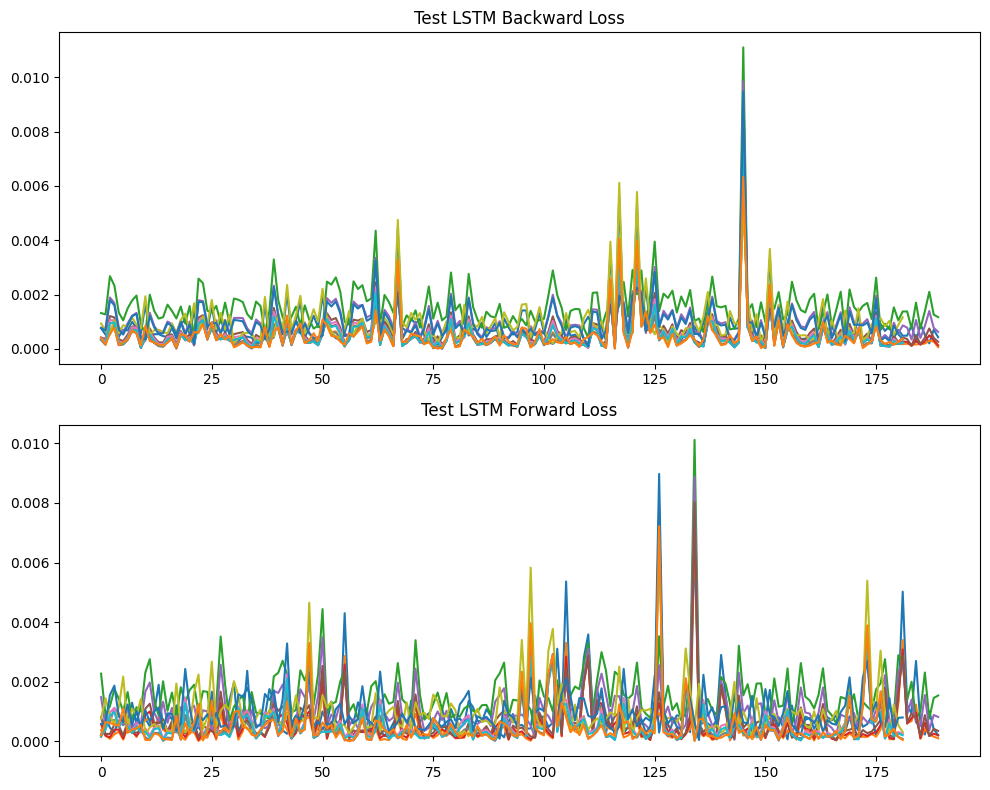

In [177]:
# Apply the function to each element of the DataFrame
df_test_lstm_loss_values_convert = df_test_lstm_loss_values.applymap(lambda x: tensor_to_number(x))
df_test_gru_loss_values_convert = df_test_gru_loss_values.applymap(lambda x: tensor_to_number(x))

plotGraph(df_test_lstm_loss_values_convert)

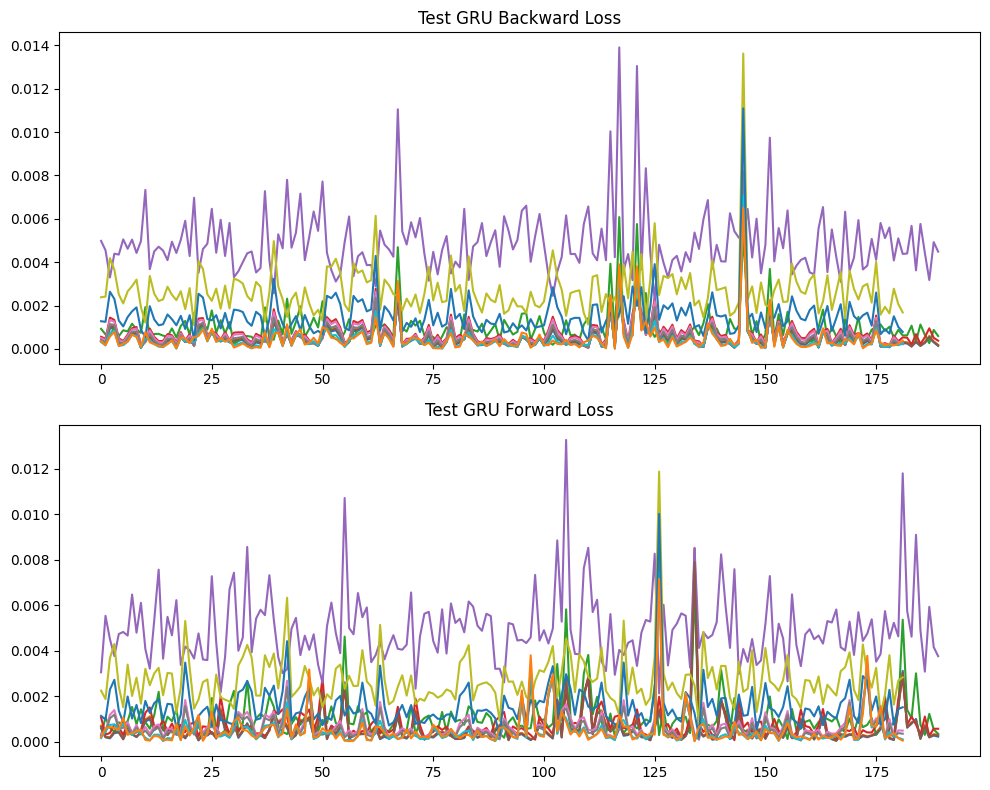

In [178]:
plotGraph(df_test_gru_loss_values_convert)